In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

%matplotlib inline

2024-05-26 00:11:25.016839: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 00:11:25.017054: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 00:11:25.019277: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 00:11:25.049819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 00:11:25.685460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

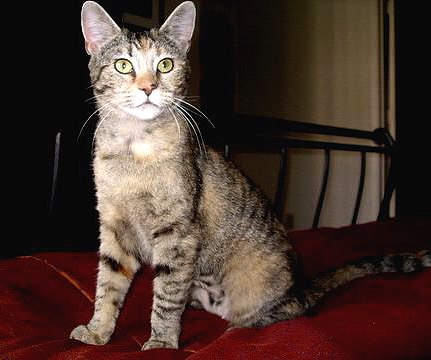

In [4]:
with Image.open("CATS_DOGS/test/CAT/10000.jpg") as im:
    display(im)

In [5]:
path="/home/shannu/Desktop/sem4/acm/CATS_DOGS"
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)


In [6]:
img_names[:1]

['/home/shannu/Desktop/sem4/acm/CATS_DOGS/train/DOG/3050.jpg']

In [7]:
img_sizes=[]
rejected=[]
for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

In [8]:
print("There are no images that are rejected")
len(img_sizes),len(rejected)

There are no images that are rejected


(24994, 0)

In [9]:
df=pd.DataFrame(img_sizes)

In [10]:
df[0].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [11]:
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

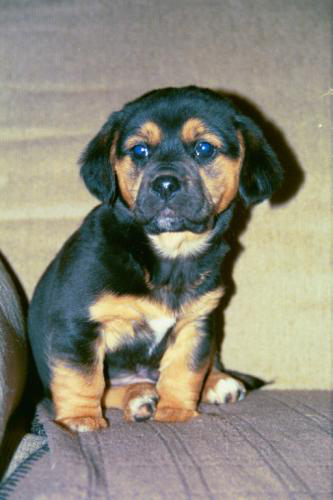

In [12]:
dog=Image.open("../acm/CATS_DOGS/train/DOG/454.jpg")

display(dog)

In [13]:
# The pixes alwasys ranges from 0 - 255t
dog.getpixel((0,0))

(112, 122, 123)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
<class 'torch.Tensor'>


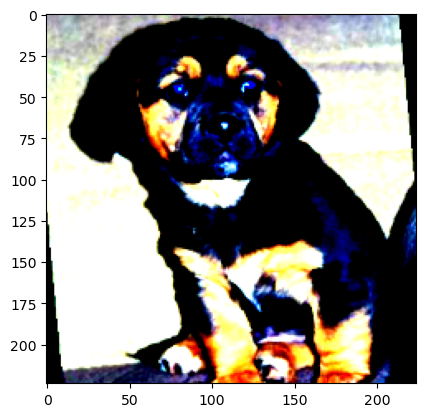

In [14]:
transform=transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
im=transform(dog)
print(im.shape)
print(type(im))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


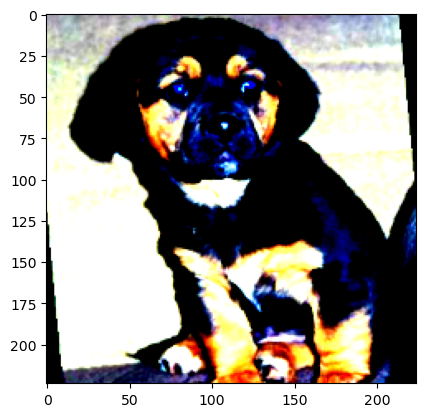

In [15]:
# The image should to transformed to 500,333,3
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [16]:
train_transform=transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
test_transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [17]:
root="../acm/CATS_DOGS/"
train_data=datasets.ImageFolder(os.path.join(root,"train"),transform=train_transform)
test_data=datasets.ImageFolder(os.path.join(root,"test"),transform=test_transform)

In [18]:
train_loader = DataLoader(train_data,shuffle=True,batch_size=10)
test_loader = DataLoader(test_data,batch_size=10)

In [19]:
class_names=train_data.classes
class_names

['CAT', 'DOG']

In [20]:
len(train_data)

18743

In [21]:
len(test_data)

6251

In [22]:
for images,labels in train_loader:
    break

In [23]:
images.shape

torch.Size([10, 3, 224, 224])

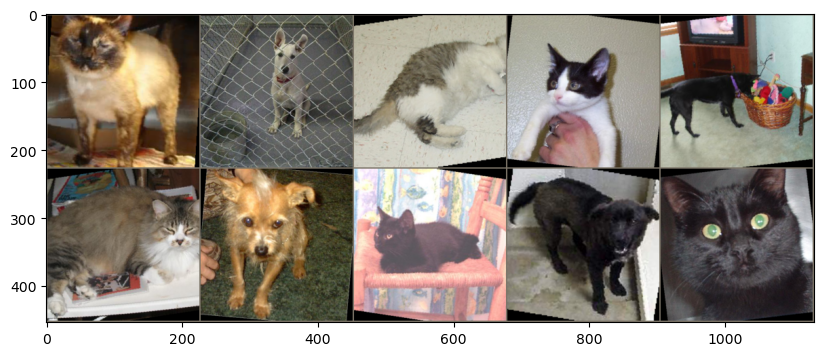

In [24]:
im=make_grid(images,nrow=5)
inv_normalize=transforms.Normalize(
    mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
    std=[1/0.229,1/0.224,1/0.225],
)
im_inv=inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [25]:
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(54*54*16,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,2)

    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2,2)
        x=x.view(-1,54*54*16)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)

        return F.log_softmax(x,dim=1)


In [26]:
torch.manual_seed(101)
CNNModel=ConvolutionNetwork()
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(CNNModel.parameters(),lr=0.1)

In [27]:
CNNModel

ConvolutionNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [29]:
start_time=time.time()
epochs=3

max_train_batch=800  #total trainable images =800*batch_size(10)
max_test_batch=300 #total testable images = 300 *batch_size(10)


train_loss=[]
test_loss=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
    train_crct=0
    test_crct=0
    for b,(X_train,y_train) in enumerate(train_loader):
        b+=1
        if b == max_train_batch:
            break
        y_pred= CNNModel(X_train)
        loss=criterion(y_pred,y_train)

        predicted=torch.max(y_pred.data,1)[1]
        batch_correct=(predicted==y_train).sum()
        train_crct+=batch_correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%100 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  accuracy: {train_crct.item()*100/(10*b):7.3f}%')

    train_correct.append(train_crct)
    
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            b+=1
            if b == max_test_batch:
                break
            y_val=CNNModel(X_test)
            predicted= torch.max(y_val.data,1)[1]
            batch_correct+=(predicted==y_test).sum()
            test_crct+=batch_correct
        loss= criterion(y_val,y_test)
        test_loss.append(loss.item())
        test_correct.append(test_crct)

print(f"The total time taken for trainining data is :{(time.time()-start_time)/60} minutes")

epoch:  0  batch:  100 [  1000/8000]  loss: 0.61099207  accuracy:  49.400%
epoch:  0  batch:  200 [  2000/8000]  loss: 0.71184033  accuracy:  49.450%
epoch:  0  batch:  300 [  3000/8000]  loss: 0.72653592  accuracy:  49.367%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.69800717  accuracy:  49.600%
epoch:  0  batch:  500 [  5000/8000]  loss: 0.70104408  accuracy:  50.660%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.66044551  accuracy:  51.000%
epoch:  0  batch:  700 [  7000/8000]  loss: 0.69561303  accuracy:  51.171%
epoch:  1  batch:  100 [  1000/8000]  loss: 0.69836164  accuracy:  49.900%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.68512058  accuracy:  51.100%
epoch:  1  batch:  300 [  3000/8000]  loss: 0.68774599  accuracy:  50.300%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.62996018  accuracy:  49.700%
epoch:  1  batch:  500 [  5000/8000]  loss: 0.68600047  accuracy:  49.640%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.72325838  accuracy:  49.867%
epoch:  1  batch:  700 [ 

In [30]:
torch.save(CNNModel.state_dict(),"Cat_dog_classification.pt")

In [32]:
train_loss

[]

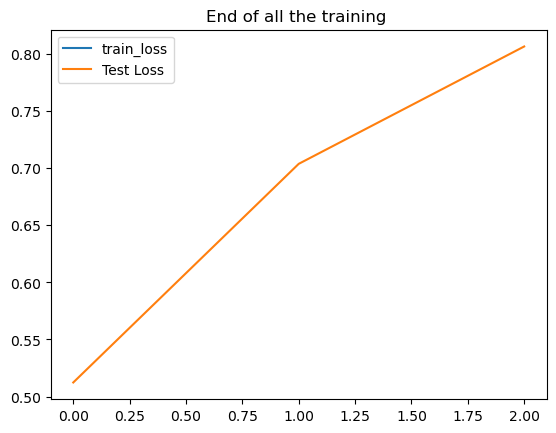

In [31]:
plt.plot(train_loss,label="train_loss")
plt.plot(test_loss,label="Test Loss")
plt.title("End of all the training ")
plt.legend()

In [34]:
test_correct

[tensor(450593), tensor(1196), tensor(1495)]

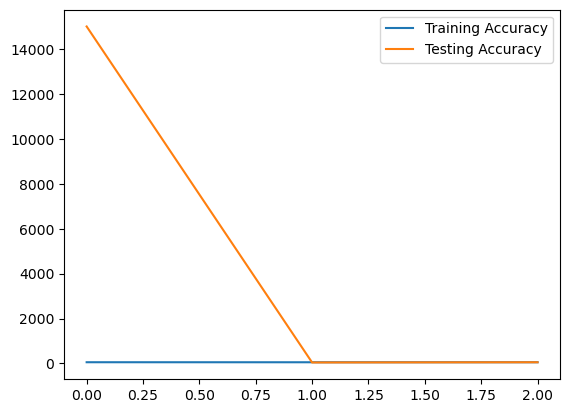

In [33]:
plt.plot([t/80 for t in train_correct],label="Training Accuracy")
plt.plot([t/30 for t in test_correct],label="Testing Accuracy")
plt.legend()